# Youtube Trend Analysis
##### Team Members: Simon, Frank and David

In [73]:
%matplotlib notebook
%matplotlib inline

In [74]:
# Load packages
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
import functools as ft
import seaborn as sns
import re  
from scipy.stats import logistic
import calendar
import random
import json

#plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

In [75]:
# Load data 
youtube_data = pd.read_csv('YouTube_Data/US_youtube_trending_data.csv', encoding='utf-8')
lookup = pd.read_csv('YouTube_Data/category_ids.csv')

In [76]:
lookup

,categoryId,category
0,2,Autos & Vehicles
1,1,Film & Animation
2,10,Music
3,15,Pets & Animals
4,17,Sports
5,18,Short Movies
6,19,Travel & Events
7,20,Gaming
8,21,Videoblogging
9,22,People & Blogs


In [77]:
youtube_data

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16793,eR3usT9bKCk,Quando Rondo - Way Up [Official Music Video],2020-10-28T17:00:11Z,UCLr1r2bBAwBPG3KJubtYyyg,Quando Rondo,10,2020-11-04T00:00:00Z,Quando Rondo|Atlantic|Records|1633|Hip|Hop|Rap...,351316,20974,339,1237,https://i.ytimg.com/vi/eR3usT9bKCk/default.jpg,False,False,Quando Rondo - Way UpStream/Download 'Diary of...
16794,8yAscSQoTgQ,Bryant Myers - Se Fuerte,2020-10-29T22:00:10Z,UCtvXogmrPwTNXOefkdKXYJg,BryantMyersVEVO,10,2020-11-04T00:00:00Z,Bryant|Myers|Fuerte|EONE|Latin,2526049,116939,1923,6081,https://i.ytimg.com/vi/8yAscSQoTgQ/default.jpg,False,False,NEW album/ NUEVO album “Bendecido” Available/...
16795,UthWoHf8wWQ,Civil TV: King Von Welcome to My Neighborhood:...,2020-10-27T22:54:10Z,UC8sl9EAOqIwKN9jcnMcdGWw,Karen Civil,24,2020-11-04T00:00:00Z,king von|o block|chicago|63rd|civiltv|karen ci...,951521,24267,903,3327,https://i.ytimg.com/vi/UthWoHf8wWQ/default.jpg,False,False,O Block's King Von is the latest artist to app...
16796,Go2-0svsdBM,LARRY WHEELS vs SCHOOLBOY LEFT-HANDED AND RIGH...,2020-10-28T19:45:09Z,UCeU05pwtEAreeF81saVb9XQ,Larry Wheels,17,2020-11-04T00:00:00Z,larry wheels|larrywheels|pr|personal record|pr...,1396497,54119,977,12181,https://i.ytimg.com/vi/Go2-0svsdBM/default.jpg,False,False,Visit Team Personal Record for NEW Programs an...


# Data Cleaning and Exploration
#### Pandas Process

* Parse youtube date format into datetime format
* Calculate lag time for each video to trend
* Replace category ID integers with category names based on youtube category dictionary
* Sort by ‘like’, most to least
* Drop duplicates
* Groupby date, calculate number of trending videos published
* Groupby category calculate number, like %, dislike %
* Groupby month, see if there are trending difference month-to-month (there are not)
* Analyze the lag time for a video to trend

In [78]:
# Function to parse dates (there is probably a built-in function, but this is what I was able to figure out)

def youtube_date_parse(df, series_to_parse, new_name_date, new_name_time, delimiting_character, drop_character):
    try:
        split = df[series_to_parse].str.split(delimiting_character, n = 1, expand = True)
        split[1] =split[1].map(lambda x: x.rstrip(drop_character))
        df[new_name_date] = split[0]
        df[new_name_time] = split[1]
        df.drop(columns = [series_to_parse], inplace=True)
        df[new_name_date] = pd.to_datetime(df[new_name_date])
        return df
    except:
        print('Already parsed, dumbass...')

In [79]:
youtube_data.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11T17:00:10Z,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12T00:00:00Z,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare..."
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11T16:34:06Z,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12T00:00:00Z,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11T16:38:55Z,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12T00:00:00Z,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11T15:10:05Z,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12T00:00:00Z,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...


In [80]:
########### Clean up data: drop columns, parse dates, replace category numbers with cateogry names, etc. #####

# Drop unneeded columns
youtube_data.drop(['video_id','channelId', 'thumbnail_link', 'comments_disabled', 'ratings_disabled'],\
                  axis=1, inplace = True)

# Convert date strings to datetime objects
youtube_date_parse(youtube_data, 'publishedAt', 'date_published', 'time_published', 'T', 'Z')
youtube_date_parse(youtube_data, 'trending_date', 'date_trending', 'time_trending', 'T', 'Z')
youtube_data.drop(['time_trending'], axis=1, inplace=True)

# The datetime functions are great, and can be used to group (see below).
# To make life easier for folks, I'm going to put month names in their own column
# notice the .dt.month syntax that works on datetime objects
youtube_data['month_published']= youtube_data['date_published'].dt.month
youtube_data['month_trending'] = youtube_data['date_trending'].dt.month
youtube_data['month_published'].replace([8,9,10,11], ['Aug', 'Sept', 'Oct', 'Nov'], inplace=True)
youtube_data['month_trending'].replace([8,9,10,11], ['Aug', 'Sept', 'Oct', 'Nov'], inplace=True)

# Calculate lag time between posting and trending.  You can do arithmetic with dates in datetime
youtube_data['lag'] = youtube_data['date_trending'] - youtube_data['date_published']

# Covert category IDs to catetory names
youtube_data['categoryId'].replace(lookup['categoryId'].tolist(), lookup['category'].tolist(), inplace=True)

# Rename columns
new_names = {'channelTitle':'channel', 'categoryId':'category', 'view_count':'views', 'comment_count':'comments'}
youtube_data.rename(columns = new_names, inplace=True)

# Sort by likes
youtube_data.sort_values('likes', ascending=False, inplace=True)


# Reorder columns for readability
new_order = ['channel', 'title', 'category', 'views', 'likes','dislikes','comments', 'date_published', 'date_trending','lag','month_published', 'month_trending', 'time_published','tags', 'description']
youtube_data=youtube_data[new_order]

# Get column names so they are handy
cols = youtube_data.columns

# Keep only the most popular posting of duplicate videos
# I could maybe try to roll the stats for duplicates together,
# but this is tricky, in that they will have different dates.
youtube_data = youtube_data.drop_duplicates(subset='title', keep='first')
youtube_data.head()



,channel,title,category,views,likes,dislikes,comments,date_published,date_trending,lag,month_published,month_trending,time_published,tags,description
3358,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official MV,Music,232649205,15735533,714194,6065230,2020-08-21,2020-08-28,7 days,Aug,Aug,03:58:10,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MVCredits:Dire...
4980,BLACKPINK,BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V,Music,184778248,11795670,879354,2735997,2020-08-28,2020-09-05,8 days,Aug,Sept,04:00:11,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK - ‘Ice Cream (with Selena Gomez)’Com...
11764,BLACKPINK,BLACKPINK – ‘Lovesick Girls’ M/V,Music,140685439,9217876,127308,1507605,2020-10-02,2020-10-09,7 days,Oct,Oct,04:00:13,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK – ‘Lovesick Girls’영원한 밤창문 없는 방에 우릴 가...
2762,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official Teaser,Music,62496726,6178664,158845,992356,2020-08-18,2020-08-25,7 days,Aug,Aug,15:00:02,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official TeaserBTS (방탄소...
3992,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official MV (B-side),Music,45596902,5951286,97683,382374,2020-08-24,2020-08-31,7 days,Aug,Aug,15:00:01,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MV (B-side)Cre...


In [81]:
# manage chinese characters 
# https://stackoverflow.com/questions/48842639/removing-chinese-in-pandas
youtube_data['title'] = youtube_data['title'].apply(lambda row: row.encode('ascii',errors='ignore').decode())
youtube_data['channel'] = youtube_data['channel'].apply(lambda row: row.encode('ascii',errors='ignore').decode())

In [82]:
youtube_data.head()


,channel,title,category,views,likes,dislikes,comments,date_published,date_trending,lag,month_published,month_trending,time_published,tags,description
3358,Big Hit Labels,BTS () 'Dynamite' Official MV,Music,232649205,15735533,714194,6065230,2020-08-21,2020-08-28,7 days,Aug,Aug,03:58:10,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MVCredits:Dire...
4980,BLACKPINK,BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V,Music,184778248,11795670,879354,2735997,2020-08-28,2020-09-05,8 days,Aug,Sept,04:00:11,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK - ‘Ice Cream (with Selena Gomez)’Com...
11764,BLACKPINK,BLACKPINK Lovesick Girls M/V,Music,140685439,9217876,127308,1507605,2020-10-02,2020-10-09,7 days,Oct,Oct,04:00:13,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK – ‘Lovesick Girls’영원한 밤창문 없는 방에 우릴 가...
2762,Big Hit Labels,BTS () 'Dynamite' Official Teaser,Music,62496726,6178664,158845,992356,2020-08-18,2020-08-25,7 days,Aug,Aug,15:00:02,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official TeaserBTS (방탄소...
3992,Big Hit Labels,BTS () 'Dynamite' Official MV (B-side),Music,45596902,5951286,97683,382374,2020-08-24,2020-08-31,7 days,Aug,Aug,15:00:01,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MV (B-side)Cre...


In [124]:
# Sum of videos published (US, 2020) according to category

youtube_data_by_cat = youtube_data.groupby(['category']).sum()
youtube_data_by_cat.reset_index(inplace=True)
youtube_data_by_cat = youtube_data_by_cat.sort_values(by='views', ascending=False)

/var/folders/08/sqgb2bt15_l6kh0_05byp_y00000gn/T/ipykernel_47173/2365720100.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  youtube_data_by_cat = youtube_data.groupby(['category']).sum()


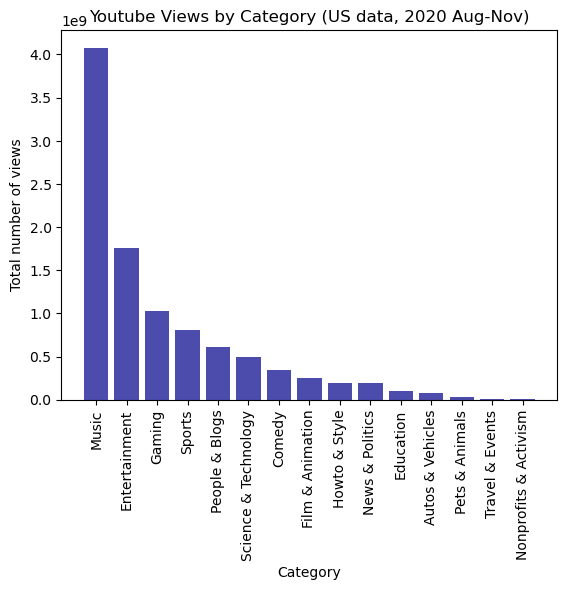

In [125]:
# plot number of views by category

plt.bar(youtube_data_by_cat['category'], youtube_data_by_cat['views'], alpha=0.7, color='darkblue', align='center')
plt.xticks(rotation=90)

plt.xlabel('Category')
plt.ylabel('Total number of views')
plt.title('Youtube Views by Category (US data, 2020 Aug-Nov)')
plt.rcdefaults()
plt.show()

In [85]:
# select only music category data

youtube_data_music_df = youtube_data.loc[youtube_data['category']=='Music']
youtube_data_music_df

,channel,title,category,views,likes,dislikes,comments,date_published,date_trending,lag,month_published,month_trending,time_published,tags,description
3358,Big Hit Labels,BTS () 'Dynamite' Official MV,Music,232649205,15735533,714194,6065230,2020-08-21,2020-08-28,7 days,Aug,Aug,03:58:10,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MVCredits:Dire...
4980,BLACKPINK,BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V,Music,184778248,11795670,879354,2735997,2020-08-28,2020-09-05,8 days,Aug,Sept,04:00:11,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK - ‘Ice Cream (with Selena Gomez)’Com...
11764,BLACKPINK,BLACKPINK Lovesick Girls M/V,Music,140685439,9217876,127308,1507605,2020-10-02,2020-10-09,7 days,Oct,Oct,04:00:13,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK – ‘Lovesick Girls’영원한 밤창문 없는 방에 우릴 가...
2762,Big Hit Labels,BTS () 'Dynamite' Official Teaser,Music,62496726,6178664,158845,992356,2020-08-18,2020-08-25,7 days,Aug,Aug,15:00:02,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official TeaserBTS (방탄소...
3992,Big Hit Labels,BTS () 'Dynamite' Official MV (B-side),Music,45596902,5951286,97683,382374,2020-08-24,2020-08-31,7 days,Aug,Aug,15:00:01,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MV (B-side)Cre...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8122,SuperM,SuperM | SuperM Midterm Exam : LUCAS TAEMIN TEN,Music,991767,0,0,5369,2020-09-18,2020-09-21,3 days,Sept,Sept,13:00:01,[None],SuperM's 1st Album Super One will be released ...
1672,SuperM,SuperM '100' MV Reaction,Music,1122081,0,0,8797,2020-08-18,2020-08-20,2 days,Aug,Aug,15:00:17,[None],SuperM's new single “100” is out!🎧Listen and d...
8792,Tyler Childers,A message from Tyler.,Music,716945,0,0,0,2020-09-18,2020-09-24,6 days,Sept,Sept,12:20:09,tyler childers|long violent history|tyler chil...,The new album - Long Violent History - is avai...
9187,THE BOYZ,THE BOYZ() THE STEALER MV,Music,12016894,0,0,30936,2020-09-21,2020-09-26,5 days,Sept,Sept,09:00:03,크래커엔터테인먼트|Cre.ker Entertainment|크래커|Creker|Cre...,THE BOYZ ‘CHASE’ on iTunes : https://apple.co/...


In [86]:
# try to find most popular music videos - sort by number of views (descending)

music_views_descending_popularity = youtube_data_music_df.sort_values(by=['views'], ascending=False)
music_views_descending_popularity.head(50)

,channel,title,category,views,likes,dislikes,comments,date_published,date_trending,lag,month_published,month_trending,time_published,tags,description
3358,Big Hit Labels,BTS () 'Dynamite' Official MV,Music,232649205,15735533,714194,6065230,2020-08-21,2020-08-28,7 days,Aug,Aug,03:58:10,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MVCredits:Dire...
4980,BLACKPINK,BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V,Music,184778248,11795670,879354,2735997,2020-08-28,2020-09-05,8 days,Aug,Sept,04:00:11,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK - ‘Ice Cream (with Selena Gomez)’Com...
11764,BLACKPINK,BLACKPINK Lovesick Girls M/V,Music,140685439,9217876,127308,1507605,2020-10-02,2020-10-09,7 days,Oct,Oct,04:00:13,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK – ‘Lovesick Girls’영원한 밤창문 없는 방에 우릴 가...
985,Cardi B,Cardi B - WAP feat. Megan Thee Stallion [Offic...,Music,98442414,3207729,467717,310630,2020-08-07,2020-08-16,9 days,Aug,Aug,04:00:10,Cardi B|Cardi|Atlantic Records|rap|hip hop|tra...,Cardi B - WAP feat. Megan Thee StallionStream/...
16161,JYP Entertainment,TWICE I CAN'T STOP ME M/V,Music,74991178,2874511,63407,929318,2020-10-26,2020-11-01,6 days,Oct,Nov,08:59:54,TWICE|트와이스|eyeswideopen mv|I cant stop me mv|i...,TWICE I CAN'T STOP ME M/VTWICE 2nd Album Eyes ...
2762,Big Hit Labels,BTS () 'Dynamite' Official Teaser,Music,62496726,6178664,158845,992356,2020-08-18,2020-08-25,7 days,Aug,Aug,15:00:02,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official TeaserBTS (방탄소...
13587,JustinBieberVEVO,Justin Bieber - Holy ft. Chance The Rapper,Music,57463872,2731390,71939,194456,2020-09-18,2020-10-18,30 days,Sept,Oct,04:00:10,justin bieber|bieber|justin|hailey|biebs|biebe...,Holy out now: https://JustinBieber.lnk.to/Holy...
13539,SMTOWN,NCT U 'Make A Wish (Birthday Song)' MV,Music,56531571,1901194,28569,493320,2020-10-12,2020-10-18,6 days,Oct,Oct,09:00:15,NCT|NCT U|NCT 127|NCT DREAM|Make a wish|RESONA...,NCT's 2nd album NCT - The 2nd Album RESONANCE ...
15557,ArianaGrandeVevo,Ariana Grande - positions (official video),Music,47606296,3140640,57939,232049,2020-10-23,2020-10-29,6 days,Oct,Oct,04:00:10,ariana grande positions|positions ariana grand...,The official “positions” music video by Ariana...
2787,Ozuna,Ozuna x Karol G x Myke Towers - Caramelo Remix...,Music,45893190,926272,40744,45413,2020-08-17,2020-08-25,8 days,Aug,Aug,20:00:13,Reggaeton music|musica|reggaeton|top reggaeton...,Ozuna x Karol G x Myke Towers - Caramelo Remix...


In [87]:
# most watched videos
# Davids note. OK i satarted looking at music and was going to look at most watched music videos. Its tricky because the same 
# videos come up under different names and channels..

# going to switch to entertainment rather than music to see what I can find out

youtube_data_ent_df = youtube_data.loc[youtube_data['category']=='Entertainment']
youtube_data_ent_df_pop_sorted = youtube_data_ent_df.sort_values(['likes'], ascending = False)
ent_grouped = youtube_data_ent_df_pop_sorted[['channel', 'views', 'title']].groupby(['views']).sum()

ent_grouped_desc = ent_grouped.sort_values(by=['views'], ascending=False)
grouped_ent = ent_grouped_desc.groupby(['channel', 'title', 'views']).sum()
grouped_ent
grouped_ent = grouped_ent.sort_values(by='views', ascending=False)
grouped_ent.head(50)

Empty DataFrame
Columns: []
Index: [(MrBeast, Last To Leave $800,000 Island Keeps It, 31801966), (MrBeast, I Bought A Private Island, 30234876), (MTV, BTS Performs Dynamite | 2020 MTV VMAs, 29442683), (MrBeast, I Gave My 40,000,000th Subscriber 40 Cars, 28567218), (MrBeast, I Filled My Brothers House With Slime & Bought Him A New One, 25904589), (MrBeast, I Survived 24 Hours Straight In Ice, 24446223), (Saturday Night Live, First Debate Cold Open - SNL, 23841894), (MrBeast, I Spent $1,000,000 On Lottery Tickets and WON, 23841821), (Warner Bros. Pictures, Dune Official Trailer, 23316424), (MrBeast, $300,000 Influencer Trivia Tournament!, 22436267), (MrBeast, Hi Me In 5 Years, 21701884), (MrBeast, Why I Havent Been Uploading, 20869977), (MrBeast, Would YOU Rather Have A Lamborghini or This House?, 20807368), (MrBeast, Would You Rather Have A Giant Diamond or $100,000?, 20086518), (James Charles, Giving JoJo Siwa A FULL MAKEOVER!, 19977004), (TREASURE (), TREASURE - 'BOY' M/V, 19682753), (Warner Bros. Pictures, The Batman - DC FanDome Teaser, 19666039), (MrBeast, Get This Random Person 1,000,000 Subscribers, 19422743), (James Charles, Doing My Best Friend's Halloween Makeup ft. Charli, Dixie, Noah, Larray & Chase, 18529000), (MrBeast, I Uberd People And Let Them Keep The Car, 18198753), (MTV, Lady Gaga Performs a Medley of Chromatica II, Rain On Me (ft. Ariana Grande), & More, 17361977), (loonatheworld, [MV]   (LOONA) Why Not?, 14922451), (America's Got Talent, BTS Performs Dynamite on AGT - America's Got Talent 2020, 14032448), (Marvel Entertainment, WandaVision | Official Trailer | Disney+, 13965881), (TREASURE (), TREASURE -  (I LOVE YOU) M/V, 13791519), (Marvel Entertainment, Chadwick Boseman Tribute, 12498164), (James Charles, Doing Kylie Jenner's Halloween Makeup!, 12485363), (Saturday Night Live, VP Fly Debate Cold Open - SNL, 12391394), (MrBeast, Get Him 1,000,000 Subscribers in 24 Hours, 12035592), ( Knowingbros, [ ] (BLACKPINK) 'How You Like That' + 'Pretty Savage'   (Knowing bros) 251, 10558129), (MrBeast, I Uberd People And Gave Them A Lamborghini, 10436587), (Universal Pictures, FREAKY - Official Trailer (HD), 10120969), (James Charles, Makeup en Espaol con Kimberly Loaiza!, 10043340), (HBO Max, Zack Snyders Justice League | Official Teaser | HBO Max, 9880996), (ZHC, Customizing A $10,000,000 House, 9464452), (Saturday Night Live, Final Debate Cold Open - SNL, 9391191), ( ?, (Eng sub) []  !   ! (Hangout with Yoo - refund sisters), 9347686), (James Charles, I Did My Makeup Horribly To See How My Friends Would React *Prank*, 9120314), (Star Wars, The Mandalorian | Season 2 Official Trailer | Disney+, 9118554), (Logan Paul, Opening The $200,000 1st Edition Pokemon Box (Official Live Stream), 8995049), (BLACKPINK, Exclusive footage of BLACKPINK revealed on RELEASED, 8962281), (Netflix, The Devil All The Time starring Tom Holland & Robert Pattinson | Official Trailer | Netflix, 8733381), (James Charles, Emma Chamberlain Picks My Outfits For A Week!, 8714278), (James Charles, I Bought My First Home! 2020 House Tour , 8691732), (STUDIO CHOOM [ ], [BE ORIGINAL] TWICE() 'I CAN'T STOP ME' (4K), 8670886), (ZHC, Surprising The Hype House With A Custom Bus, 8507333), (Saturday Night Live, Dueling Town Halls Cold Open - SNL, 8186822), (James Charles, DMing Celebrities To Pick My Makeup!, 7966976), (James Charles, I Adopted a Child for a Day!, 7751294), (MTV, Doja Cat Performs Say So & Like That | 2020 MTV VMAs, 7597952)]

In [88]:
grouped_ent_channel = grouped_ent.groupby(['channel', 'views'])
grouped_ent_channel_sorted = grouped_ent_channel.sum().sort_values(['views'], ascending=False)
grouped_ent_channel_sorted_top10 = grouped_ent_channel_sorted.head(50)
grouped_ent_channel_sorted_top10.reset_index(inplace=True)
grouped_ent_channel_sorted_top10

,channel,views
0,MrBeast,31801966
1,MrBeast,30234876
2,MTV,29442683
3,MrBeast,28567218
4,MrBeast,25904589
5,MrBeast,24446223
6,Saturday Night Live,23841894
7,MrBeast,23841821
8,Warner Bros. Pictures,23316424
9,MrBeast,22436267


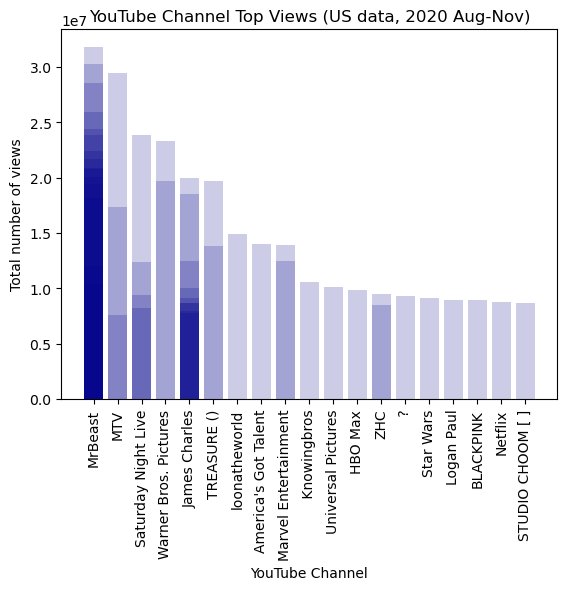

In [123]:
plt.bar(grouped_ent_channel_sorted_top10['channel'], grouped_ent_channel_sorted_top10['views'], alpha=0.2, color='darkblue', align='center')
plt.xticks(rotation=90)

plt.xlabel('YouTube Channel')
plt.ylabel('Total number of views')
plt.title('YouTube Channel Top Views (US data, 2020 Aug-Nov)')
plt.rcdefaults()
#plt.grid(False)
plt.show()

In [ ]:
# See how many videos were published each day in the dataset
# Remember, the youtube data set is a subset of of trending videos in the US, not all videos
pub_by_date = youtube_data[['title', 'date_published']].groupby('date_published')\
.count().rename(columns={'title':'number_published'})
pub_by_date

In [ ]:
# And plot the number published each day
# I could see if there are trends by days of the week
plt.style.use('ggplot')
plt.plot(pub_by_date['number_published'])
plt.xticks(rotation=75)

In [ ]:
# Categories looks at total published, likes, and dislikes.
# Only the news and politics have significant dislikes


In [ ]:
# Plot number of vids in each category
# Someone could add the x labels.  I'm bad at it.
 


In [ ]:
# See if there are any trends by month.
# There are not.



In [ ]:
#See how long it takes a video to trend.
# We have a single outlier at 30 days, which we could chop off in subsequent work.


In [ ]:
# Produce the most popular videos for a user



## Plotting Process with Matplotlib/Pandas:
* Using the previously created PANDAS dataframe, created additional layers to parse specific data per month,
* This included trending categories and user statistics.
* Added supplemental grouby functions to organize this data. 
* Create bar and scatter graphs using pyplot. 
* The heatmap was created with a correlation function and seaborn.

In [ ]:
#Coorelation between youtube scrubbed dat


In [ ]:
#Coorelation heatmap using Seaborn



In [ ]:
#Extract Channel Views by Trending Month


In [ ]:
#Classify Top Trending Channels by Month for August


In [ ]:
#Classify Top Trending Channels by Month for September


In [ ]:
#Classify Top Trending Channels by Month for October


In [ ]:
#Classify Top Trending Channels by Month for November


In [ ]:
#Graph August


In [ ]:
#Graph September



In [ ]:
#Graph October



In [ ]:
#Graph November



In [ ]:
#Prep
#create columns of percentage of likes and dislikes


In [ ]:
#Prep
#df of the top 100


In [ ]:
#Scatter Plots of likes and dislikes on a date from all four months based on views
#not 100% convinced scatter plots work for this
#August starts on the 13th, full month of Sept and Oct, Nov is only 1-5th

#input_date = input(f'Enter a date to see what was trending that day example month/day/year')
#date=df[df['date_trending']==input_date]

#subplots initilizer


#supplot 1
#initialize

#filter by specific day

#subplot (rows, columns, locate)


#subplot 2
#initialize

#filter by specific day

#subplot (rows, columns, locate)



#subplot 3
#initialize

#filter by specific day

#subplot (rows, columns, locate)


#subplot 4
#initialize

#filter by specific day

#subplot (rows, columns, locate)
  



In [ ]:
#scatter plots likes, dislikes and comments per category based on views
#top 8 categorys
#subplots initilizer
 


#subplot 2
 


#subplot 3
#initialize

#subplot 4
#initialize



#subplot 5
#initialize


#subplot 6
#initialize



#subplot 7
#initialize
 


#subplot 8
#initialize
 




In [ ]:
#Discord analsys: Shows reactions based on percet likes/dislikes if key term found in titles 
#subplots initilizer


In [ ]:
#User input key term search to see percentage likes and dislikes for a key term
#subplots initilizer


In [ ]:
#subplots initilizer


In [ ]:
#Scatter of reactions of top 100 views and percent of likes and dislikes
#subplots initilizer


In [ ]:
#export clean data


# EXPLORING YOUTUBE API:
* Collect data sample from YouTube API that contains top 50 most viewed YouTube videos in a month of 2019 and 2020.
* Also specifically look for top 50 Quarantine Challenges by view count during strict COVID Lockdown in US.



In [ ]:
# Dependencies


# API Exploration Process:
#### There are three kinds of data searches used: 
  * YouTube search, items with snippet descriptions
  * YouTube video, to get video statistics
  * youtube channel, to get channel statistic
  * all the above three files all linked by the unique video_id and channel_id field. 

### Relevant videos on youtube in April 2019:

In [ ]:
#lookthrough youtube api and get top 50 relevant videos published between in April 2019


# Data Cleaning Process:
   #### Once we pulled the necessary data:
   * Stored the API data collected to a local folder so no need to run API everytime
   * Create dataframs 
   * Merge data sets based on the video ID and channel ID fields. 
   * Sorted  the data based on view count, number of likes and dislikes. 
   * Rename and rearrange for better readablility
   * Drop irrelevant columns

In [ ]:
#


### Relevant videos on youtube in April 2020:

In [ ]:
#lookthrough youtube api and get top 50 relevant videos published in April 2020



# Data Cleaning:
* Create dataframs 
* Rename and rearrange for better readablility
* Mearge and drop irrelevant columns

In [ ]:
#df_video_ids, unpacks the dictionary stored in "id" and creats a data frame


In [ ]:
#create df


In [ ]:
comment_words = '' 
stopwords = set(STOPWORDS) 


# Top 50 Quarantine Challenges:
* During strict lockdown(03/15/2020 through 06/15/2020)

In [ ]:
#youtube, looking through youtube api


# Data Cleaning:
* Create dataframs 
* Rename and rearrange for better readablility
* Drop irrelevant columns

In [ ]:
#df_video_ids, unpacks the dictionary stored in "id" and creats a data frame


In [ ]:
#creat a df


In [ ]:
top_viewed = top10_qc
# Top quarantine challenge videos by view count


In [ ]:
#create wordcloud 


In [ ]:
#export clean data
